# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

## Introducción al Aprendizaje Automático

### Laboratorio 2: Armado de un esquema de aprendizaje automático

Grupo 30:

- Camino, Fernando
- Herrador, Emanuel Nicolás
- Rapoport, Juana
- Stutz, Sebastián
- Szurlewicz, Juan Ignacio

---


## Índice


- [1. Introducción](#1-introducción)
- [2. Desarrollo previo](#2-desarrollo-previo)
  - [2.1. Importación de librerías](#21-importación-de-librerías)
  - [2.2. Carga de datos](#22-carga-de-datos)
- [3. Descripción de los datos](#3-descripción-de-los-datos)
- [4. Análisis y manipulación de los datos](#4-análisis-y-manipulación-de-los-datos)
  - [4.1. Análisis de outliers](#41-análisis-de-outliers)
  - [4.2. Análisis de correlaciones](#42-análisis-de-correlaciones)
  - [4.3. División entre target y variables](#43-división-entre-target-y-variables)
  - [4.4. Escalado de los datos](#44-escalado-de-los-datos)
  - [4.5. División en conjuntos de entrenamiento y de evaluación](#45-división-en-conjuntos-de-entrenamiento-y-de-evaluación)
- [5. Predicción de Target](#5-predicción-de-target)
  - [5.1. Modelos de Clasificación Lineales](#51-modelos-de-clasificación-lineales)
    - [5.1.1. Modelos Lineales de Clasificación con hiperparámetros por defecto](#511-modelos-lineales-de-clasificación-con-hiperparámetros-por-defecto)
    - [5.1.2. Modelos Lineales de Clasificación con hiperparámetros ajustados](#512-modelos-lineales-de-clasificación-con-hiperparámetros-ajustados)
  - [5.2. Modelos de Árboles de Decisión](#52-modelos-de-árboles-de-decisión)
    - [5.2.1. Modelos de Árboles de Decisión con hiperparámetros por defecto](#521-modelos-de-árboles-de-decisión-con-hiperparámetros-por-defecto)
    - [5.2.2. Modelos de Árboles de Decisión con hiperparámetros ajustados](#522-modelos-de-árboles-de-decisión-con-hiperparámetros-ajustados)
  - [5.3. Comparación de Modelos](#53-comparación-de-modelos)
- [6. Conclusiones](#6-conclusiones)


## 1. Introducción


En el presente laboratorio, se propone la implementación y el análisis de rendimiento de diferentes Modelos de Clasificación Lineales y Árboles de Decisión, considerando tanto los hiperparámetros _por defecto_, como así también su posterior ajuste mediante _Grid Search_.

De este modo, se buscará evaluar el rendimiento de cada modelo (y posteriormente hacer una comparativa) en los conjuntos de entrenamiento y evaluación, midiendo la _exactitud_, la _precisión_, el _recall_ y el _f1-score_ de cada uno de ellos.

El objetivo que se persigue con este trabajo es poner en práctica los conocimientos adquiridos en la materia, trabajando con un conjunto de datos real e introducirnos en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

Respecto al [_dataset_](https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv) que se va a considerar, este está basado en el dataset de [_Kaggle Home Equity_](https://www.kaggle.com/ajay1735/hmeq-data) y contiene información de referencia y desempeño de préstamos hipotecarios "recientes".


## 2. Desarrollo previo


### 2.1. Importación de librerías


Las librerías que usaremos en el presente proyecto son las siguientes:


In [1]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
from sklearn.exceptions import ConvergenceWarning

# Seteamos la seed para reproducibilidad
np.random.seed(0)

# Ignoramos warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### 2.2. Carga de datos


Ahora, se procederá a cargar el dataset _loan_data_ para tenerlo disponible en la realización del laboratorio.


In [2]:
# Leer dataset con los comentarios
file_url = 'https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv'
df = pd.read_csv(file_url, comment="#")

## 3. Descripción de los datos


El _dataset_ contiene datos recopilados de solicitantes recientes de créditos a quienes se les otorgó mediante el proceso de suscripción de préstamos. Contiene información de referencia y desempeño de los préstamos, junto con una variable que indica si el solicitante finalmente incumplió o no con el préstamo.

En definitiva, los datos de los que disponemos son:

- _Target_: variable objetivo que indica si el solicitante incumplió o no con el préstamo ($1$ en caso afirmativo, $0$ sino).
- _Loan_: monto de la solicitud del préstamo.
- _MortDue_: monto adeudado de la hipoteca existente.
- _Value_: valor de la propiedad actual
- _YoJ_: años en el trabajo actual
- _Derog_: número de informes negativos importantes
- _Delinq_: número de líneas de crédito morosas
- _ClAge_: antigüedad de la línea de crédito más antigua (en meses)
- _NInq_: número de líneas de crédito recientes
- _ClNo_: número de líneas de crédito
- _DebTInc_: relación deuda-ingreso

Respecto a la predicción de _Target_, muchos factores incluidos en el dataset pueden influir en la probabilidad de que un solicitante incumpla con el préstamo, aunque muchos de ellos pueden estar correlacionados entre sí.

Por ese mismo motivo, se considera que las variables más determinantes serán aquellas que indiquen pre-existencia morosa en el solicitante (_Derog_ y _Delinq_), la relación deuda-ingreso (_DebTInc_) y la antigüedad de la línea de crédito más antigua (_ClAge_).


## 4. Análisis y manipulación de los datos


Antes de la predicción, debemos realizar un análisis a nuestro dataset para entender mejor cómo se comportan nuestros datos, detectar posibles _outliers_, _correlaciones_ y si es necesario realizar algún tipo de escalado o normalización de los datos.


### 4.1. Análisis de _outliers_


En este punto, analizaremos los valores atípicos presentes en nuestro dataset, por lo que haremos uso de la gráfica _boxplot_ para visualizarlos.


In [3]:
def graph_box_plot(df):
    fig = make_subplots(rows=3, cols=4)

    for i, column in enumerate(df.columns):
        if i == 0:
            continue

        row = (i - 1) // 4 + 1
        col = (i - 1) % 4 + 1
        fig.add_trace(go.Box(y=df[column], name=column), row=row, col=col)

    fig.update_layout(height=800, width=1000,
                      title_text="Boxplot de las variables del dataset")
    fig.show()


graph_box_plot(df)

Aquí, podemos observar que nuestros datos contienen una gran cantidad de valores atípicos en todas las variables y con gran diferencia respecto a la media y la mediana de los datos.

Por ello mismo, para evitar que estos valores atípicos afecten el rendimiento de nuestros modelos, consideraremos quedarnos con los valores que se encuentren debajo del percentil $99$ de todas las variables.

Haciendo esto, podemos ver la visualización con gráficos de caja para notar la disminución de los valores atípicos presente en la muestra.


In [4]:
# Filtramos los outliers
percentile_99 = df.quantile(0.99)

df2 = df.copy()

for column in df2.columns:
    df2 = df2[df2[column] <= percentile_99[column]]

print(f"Se eliminaron {df.shape[0] - df2.shape[0]} filas")

# Graficamos nuevamente los boxplots
graph_box_plot(df2)

Se eliminaron 140 filas


Gracias a lo cual, con esta eliminación de valores extremos, podemos continuar con el análisis de los datos sin que la _predicción_ posterior se vea afectado por ellos.


### 4.2. Análisis de correlaciones


A fines prácticos y de convalidar lo analizado en el anterior punto sobre la descripción de los valores de nuestro dataset, analizaremos la correlación entre las diferentes variables.

Por ello mismo, haremos uso de la matriz de correlación:


In [5]:
def graph_corr(df):
    corr = df.corr()

    fig = go.Figure(data=go.Heatmap(z=corr, x=corr.columns,
                    y=corr.columns, colorscale='Viridis'))
    fig.update_layout(height=800, width=800,
                      title_text="Correlación entre variables")

    fig.show()


graph_corr(df2)

Gracias a lo cual, podemos observar que no nos encontrábamos en lo correcto acerca de la correlación entre las variables, ya que la mayor se da únicamente entre _mortdue_ y _value_ con $0.87$.

Por ello mismo, este es un factor importantísimo que nos indica que todas las columnas que tenemos son relevantes para la predicción, dado que no se correlacionan linealmente entre ellas.


### 4.3. División entre target y variables


Para proseguir luego con el escalado de los datos y, posteriormente, con la división en los conjuntos de entrenamiento y evaluación, primero lo que haremos será dividir nuestras columnas en el target (y) y las features (X):


In [6]:
X, y = df2.iloc[:, 1:], df2.TARGET

print(f"X columns: {X.columns}")
print(f"y columns: {y.name}")

X columns: Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC'],
      dtype='object')
y columns: TARGET


De ese modo, podemos proseguir con el análisis y la manipulación de los datos.


### 4.4. Escalado de los datos


Dado que los valores de nuestras variables tienen distinto peso entre sí y es muy notable (_value_ vs. _derog_ por ejemplo), para evitar que nuestro modelo y nuestras posteriores predicciones se vean afectadas por ello, decidimos escalar los datos con el uso del _RobustScaler_. Así, tenemos que:


In [7]:
X2 = RobustScaler().fit_transform(X)
display(pd.DataFrame(X2, columns=X.columns).head())

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,-1.043860,0.493767,0.430343,-0.1,0.0,0.0,0.082925,-0.5,0.545455,-0.602497
1,0.236842,-0.635931,0.150411,-0.3,0.0,0.0,-0.293065,-0.5,-0.636364,-0.363974
2,-0.956140,0.106946,-0.273853,-0.5,0.0,0.0,-0.715495,-0.5,-0.545455,0.622539
3,-0.315789,-0.519696,-0.701151,-0.7,1.0,0.0,0.107357,0.0,-0.818182,-0.664452
4,0.236842,0.135035,0.245875,0.4,0.0,0.0,0.185027,0.0,-0.727273,-0.451719


Luego, con ello podemos asegurarnos que ninguna variable va a tener un peso mayor en la _predicción_ simplemente por su escala.


### 4.5. División en conjuntos de entrenamiento y de evaluación


Finalmente, para preparar nuestro conjunto de datos para la elección de los modelos de clasificación, dividiremos nuestros datos en dos conjuntos: _entrenamiento_ y _evaluación_. Para ello, consideraremos que cada uno representará el $80\%$ y $20\%$ del total.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=0)

print(f"X_train shape: {X_train.shape} vs. X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape} vs. y_test shape: {y_test.shape}")

X_train shape: (1371, 10) vs. X_test shape: (343, 10)
y_train shape: (1371,) vs. y_test shape: (343,)


Luego, ya podemos continuar con la implementación y el análisis del rendimiento de los diferentes modelos.


## 5. Predicción de _Target_


Para realizar las predicciones y evaluar el rendimiento de los diferentes modelos, vamos a considerar el uso de las siguientes funciones auxiliares de cálculo, comparación y muestra de métricas:


In [9]:
def show_metrics(y_true, y_pred, title):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    matrix_conf = confusion_matrix(y_true, y_pred)

    headers = ['accuracy', 'precision', 'recall', 'f1', 'TN', 'FP', 'FN', 'TP']
    values = [acc, prec, rec, f1, matrix_conf[0, 0],
              matrix_conf[0, 1], matrix_conf[1, 0], matrix_conf[1, 1]]
    display(pd.DataFrame([values], columns=headers, index=[title]))

    ConfusionMatrixDisplay(matrix_conf).plot()
    plt.show()


def compare_metrics(y_true_1, y_pred_1, y_true_2, y_pred_2, title_1, title_2):
    acc_1 = accuracy_score(y_true_1, y_pred_1)
    acc_2 = accuracy_score(y_true_2, y_pred_2)

    prec_1 = precision_score(y_true_1, y_pred_1)
    prec_2 = precision_score(y_true_2, y_pred_2)

    rec_1 = recall_score(y_true_1, y_pred_1)
    rec_2 = recall_score(y_true_2, y_pred_2)

    f1_1 = f1_score(y_true_1, y_pred_1)
    f1_2 = f1_score(y_true_2, y_pred_2)

    fig = go.Figure(go.Bar(x=['Accuracy', 'Precision', 'Recall', 'F1'], y=[
                    acc_1, prec_1, rec_1, f1_1], name=title_1, marker_color='blue'))

    fig.add_trace(go.Bar(x=['Accuracy', 'Precision', 'Recall', 'F1'], y=[
                  acc_2, prec_2, rec_2, f1_2], name=title_2, marker_color='red'))

    fig.update_layout(title_text=f"Métricas para {title_1} vs. {title_2}",
                      barmode='group', xaxis_tickangle=-45)

    fig.show()

### 5.1. Modelos de Clasificación Lineales


Para este punto, primero haremos un análisis previo con los _hiperparámetros_ por defecto para ver el rendimiento de nuestro modelo, y luego lo compararemos con las variantes que hay si los ajustamos. Esto nos dará una idea de lo importante que es la correcta elección de los _hiperparámetros_ para obtener un modelo eficiente, preciso y certero.


#### 5.1.1. Modelos Lineales de Clasificación con hiperparámetros por defecto


Si procuramos realizar la predicción de _Target_ con _SGDClassifier_ con los hiperparámetros por defecto, obtenemos lo siguiente:


,accuracy,precision,recall,f1,TN,FP,FN,TP
Métricas en Train,0.869438,0.693878,0.171717,0.275304,1158,15,164,34


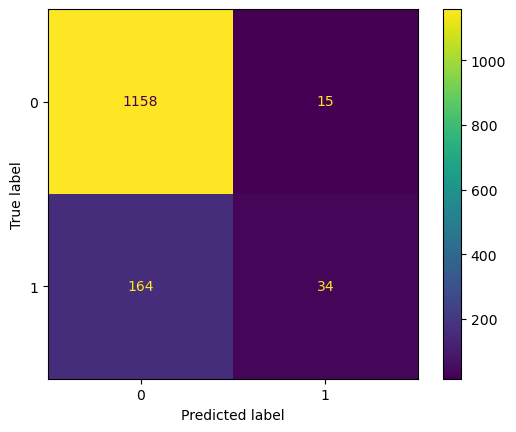

,accuracy,precision,recall,f1,TN,FP,FN,TP
Métricas en Test,0.868805,0.692308,0.18,0.285714,289,4,41,9


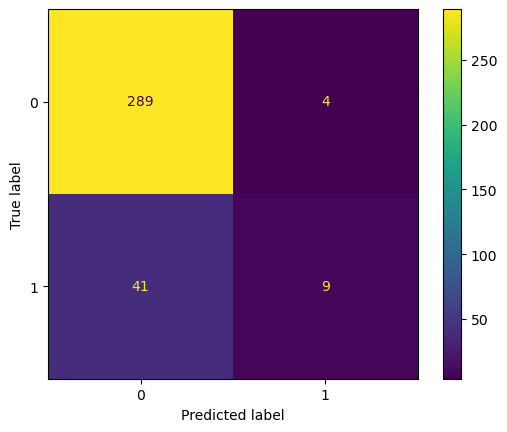

In [10]:
# Entrenamos el modelo
clf_def = SGDClassifier(random_state=10)
clf_def.fit(X_train, y_train)

# Obtenemos las predicciones
y_train_pred_clf_def = clf_def.predict(X_train)
y_test_pred_clf_def = clf_def.predict(X_test)

# Calculamos las métricas
show_metrics(y_train, y_train_pred_clf_def, "Métricas en Train")
show_metrics(y_test, y_test_pred_clf_def, "Métricas en Test")

Lo cual implica una buena primera aproximación, pero que puede ser mejorada con el ajuste de los hiperparámetros. Para un mejor análisis, comparemos las métricas obtenidas de entrenamiento y evaluación:


In [11]:
compare_metrics(y_train, y_train_pred_clf_def, y_test,
                y_test_pred_clf_def, "Train", "Test")

Ahora, tenemos la base sobre la cual notar los beneficios que existen al poder ajustar los hiperparámetros de nuestro modelo.


#### 5.1.2. Modelos Lineales de Clasificación con hiperparámetros ajustados


En este punto, probaremos varios modelos con diferentes hiperparámetros para ver cuál es el que mejor se ajusta a nuestro _dataset_ y nuestro problema de predicción. Por ello mismo, usaremos _GridSearchCV_ para probar todas las combinaciones posibles y _5-fold cross validation_ (se usa internamente dentro de _GridSearchCV_) para calcular el rendimiento de nuestro modelo en diferentes conjuntos de entrenamiento y evaluación (para asegurarnos que el modelo generalice bien a datos no vistos y no esté sobreajustado, i.e., overfitting, a los datos de entrenamiento).


In [12]:
# Cross validation con 5 folds y scoring 'accuracy'
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001],
    'max_iter': [1000, 2000, 3000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01],
}

clf_adj = SGDClassifier(random_state=10)

grid_cv = GridSearchCV(clf_adj, param_grid, scoring='accuracy', cv=5)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=10),
             param_grid={'alpha': [0.0001, 0.001], 'eta0': [0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge', 'perceptron'],
                         'max_iter': [1000, 2000, 3000],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='accuracy')

In [13]:
# Obtener la tabla con los resultados (parámetros, accuracy y su varianza)
header = [x for x in param_grid.keys()] + ['mean_test_score', 'std_test_score']
values = [grid_cv.cv_results_['param_' + x if i <
                              len(header) - 2 else x] for i, x in enumerate(header)]

# Crear un DataFrame con los resultados y ordenar por mean_test_score
clf_results = pd.DataFrame({k: v for k, v in zip(header, values)})
clf_results = clf_results.sort_values('mean_test_score', ascending=False)
clf_results = clf_results.round(5)

# Mostrar los resultados de forma interactiva
fig = go.Figure(data=[go.Table(
    header=dict(values=list(clf_results.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[clf_results[x] for x in clf_results.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(
    title_text="Resultados de los ajustes de hiperparámetros para SGDClassifier")

fig.show()

Gracias a lo cual podemos ver todos los resultados y el rendimiento de cada uno de los modelos con cada combinación de hiperparámetros posible (de los que probamos). Por ello mismo, consideremos ahora el mejor de todos ellos (_notar que no necesariamente es el primero en la tabla anterior, porque puede haber varios empates en el score_):


In [14]:
# Ver los mejores hiperparámetros
display(pd.DataFrame(grid_cv.best_params_, index=['Valor']))

,alpha,eta0,learning_rate,loss,max_iter,penalty
Valor,0.001,0.001,optimal,log_loss,1000,elasticnet


Ahora, dado esto, calculemos las métricas de evaluación para el mejor modelo obtenido, con el objetivo de poder realizar una comparación con el caso anterior (_por default_):


,accuracy,precision,recall,f1,TN,FP,FN,TP
Métricas en Train,0.865062,0.658537,0.136364,0.225941,1159,14,171,27


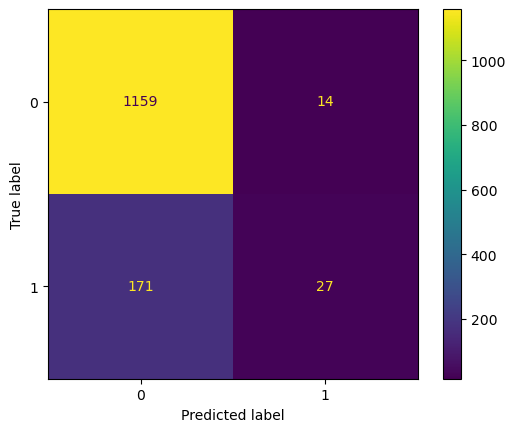

,accuracy,precision,recall,f1,TN,FP,FN,TP
Métricas en Test,0.877551,0.833333,0.2,0.322581,291,2,40,10


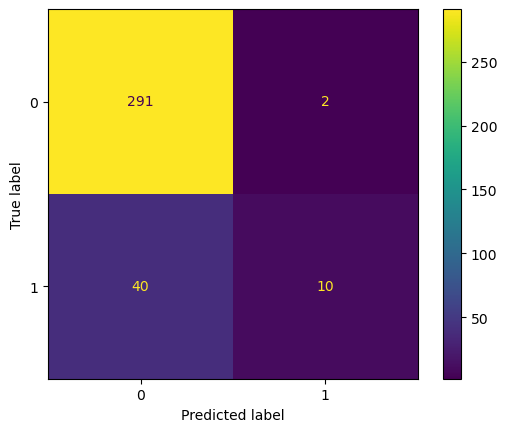

In [15]:
# Calcular el rendimiento del mejor modelo
clf_best_model = grid_cv.best_estimator_

y_train_pred_clf_adj = clf_best_model.predict(X_train)
y_test_pred_clf_adj = clf_best_model.predict(X_test)

show_metrics(y_train, y_train_pred_clf_adj, "Métricas en Train")
show_metrics(y_test, y_test_pred_clf_adj, "Métricas en Test")

Por ello mismo, si queremos comparar respecto a los resultados obtenidos en el item anterior, tenemos lo siguiente:


In [16]:
compare_metrics(y_train, y_train_pred_clf_def, y_train,
                y_train_pred_clf_adj, "Train Default", "Train Ajustado")
compare_metrics(y_test, y_test_pred_clf_def, y_test,
                y_test_pred_clf_adj, "Test Default", "Test Ajustado")

Gracias a lo cual, podemos ver que el ajuste de los hiperparámetros nos permitió mejorar el rendimiento de nuestro modelo, obteniendo una mayor _exactitud_, _precisión_, _recall_ y _f1-score_ para nuestro conjunto de evaluación, pese a que haya "empeorado" en el conjunto de entrenamiento. Sin embargo, notemos que la baja de rendimiento en el conjunto de entrenamiento se debe a que el cálculo de mejor modelo se realiza con _5-fold cross validation_, por lo que el modelo final es el que mejor generaliza a datos no vistos y evita overfitting.


### 5.2. Modelos de Árboles de Decisión


Se trabajará de forma totalmente análoga a lo realizado en el punto anterior, pero considerando ahora el uso de los modelos de _Árboles de Decisión_ , más específicamente de _DecisionTreeClassifier_.

De este modo, se procederá a realizar un análisis previo con los _hiperparámetros_ por defecto para ver el rendimiento de nuestro modelo, y luego lo compararemos con las variantes que hay si los ajustamos. Esto nos dará una idea de lo importante que es la correcta elección de los _hiperparámetros_ para obtener un modelo eficiente, preciso y certero.


#### 5.2.1. Modelos de Árboles de Decisión con hiperparámetros por defecto


Si procedemos a realizar la predicción de _Target_ con _DecisionTreeClassifier_ con los hiperparámetros por defecto, obtenemos lo siguiente:


,accuracy,precision,recall,f1,TN,FP,FN,TP
Métricas en Train,1.0,1.0,1.0,1.0,1173,0,0,198


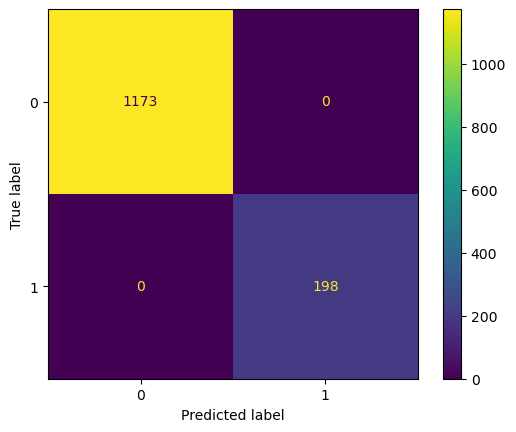

,accuracy,precision,recall,f1,TN,FP,FN,TP
Métricas en Test,0.886297,0.634146,0.52,0.571429,278,15,24,26


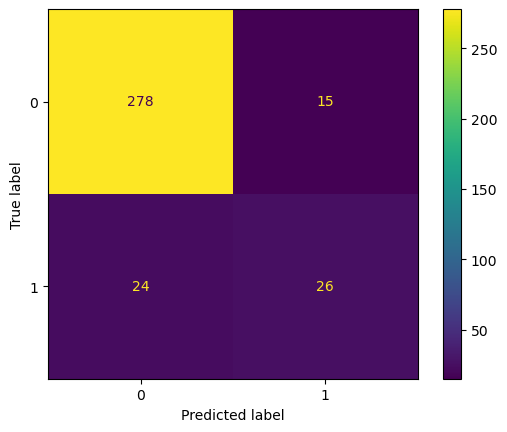

In [17]:
# Entrenamos el modelo
dtc_def = DecisionTreeClassifier(random_state=10)
dtc_def.fit(X_train, y_train)

# Obtenemos las predicciones
y_train_pred_dtc_def = dtc_def.predict(X_train)
y_test_pred_dtc_def = dtc_def.predict(X_test)

# Calculamos las métricas
show_metrics(y_train, y_train_pred_dtc_def, "Métricas en Train")
show_metrics(y_test, y_test_pred_dtc_def, "Métricas en Test")

Lo cual es, claramente, un rotundo sobreajuste sobre los datos de entrenamiento. Esto se puede ver más a detalle en la comparativa de las métricas de los dos conjuntos de datos:


In [18]:
compare_metrics(y_train, y_train_pred_dtc_def, y_test,
                y_test_pred_dtc_def, "Train", "Test")

Por ello, pese a que sean bastante mejores los valores obtenidos para el conjunto de evaluación respecto a los obtenidos con _SGDClassifier_, el sobreajuste es un problema que debemos solucionar. Para ello, trabajaremos con el ajuste de los hiperparámetros y _5-fold cross validation_ para que el modelo generalice bien a datos no vistos.

Finalmente, y a fines ilustrativos, el árbol de decisión obtenido con los hiperparámetros por defecto es el siguiente:


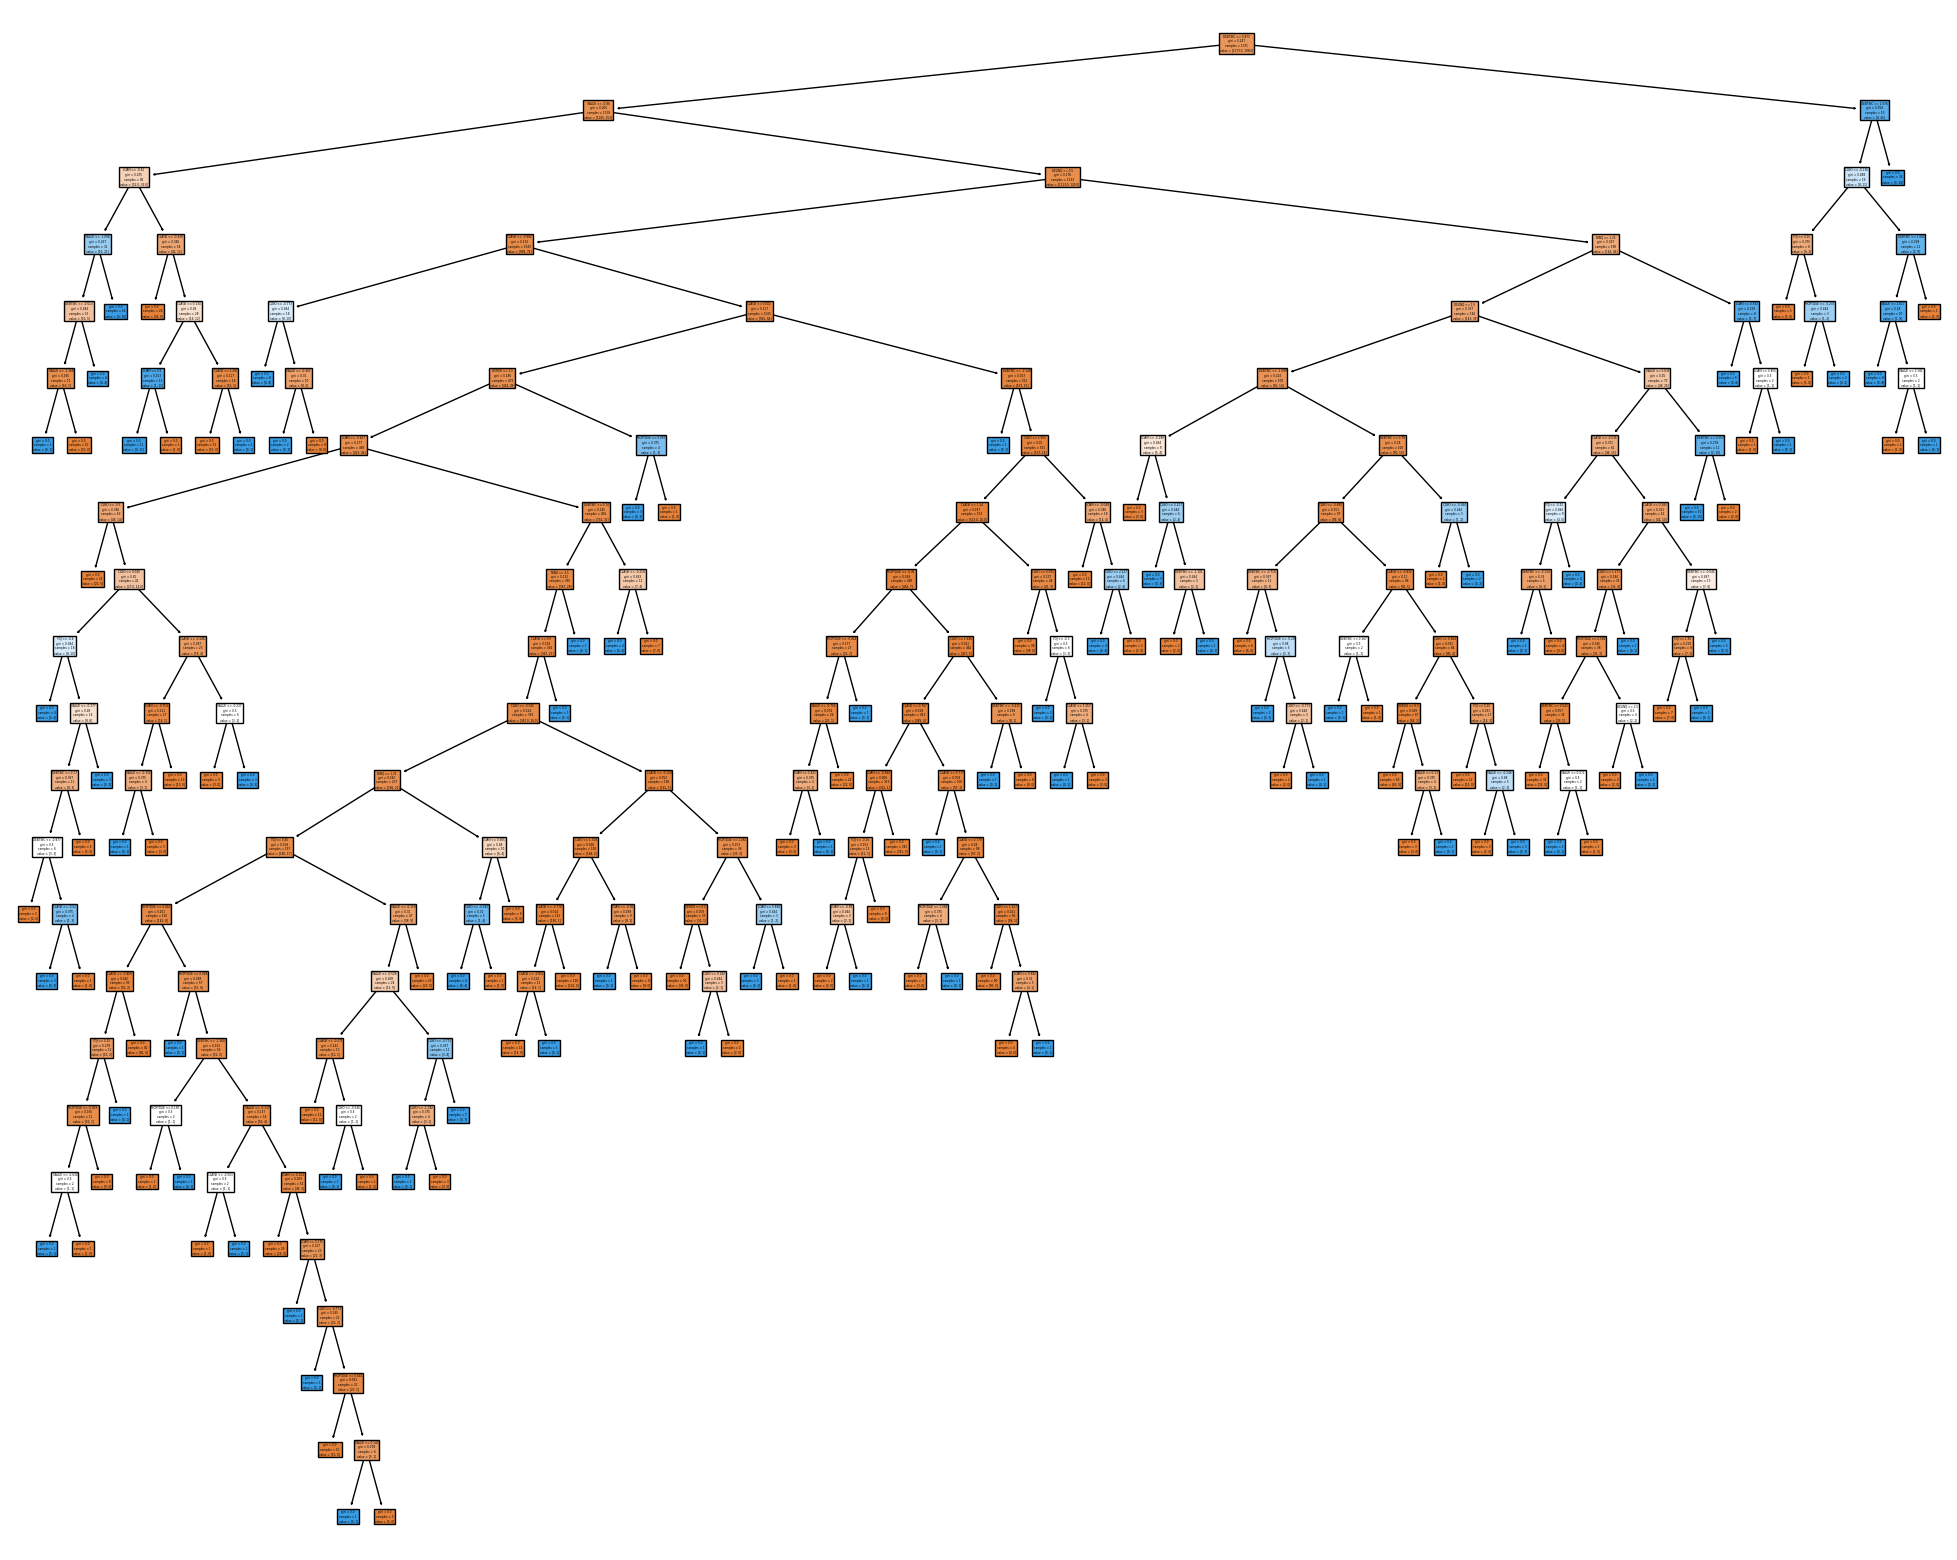

In [19]:
fig = plt.figure(figsize=(25, 20))
plot_tree(dtc_def, filled=True, feature_names=X.columns)
plt.show()

#### 5.2.2. Modelos de Árboles de Decisión con hiperparámetros ajustados


Por el sobreajuste notado en el punto anterior, procederemos a ajustar los hiperparámetros de nuestro modelo para obtener un mejor rendimiento en el conjunto de evaluación. Para ello, usaremos _GridSearchCV_ para probar todas las combinaciones posibles y _5-fold cross validation_ para calcular el rendimiento de nuestro modelo en diferentes conjuntos de entrenamiento y evaluación, evitando así el sobreajuste y favoreciendo la generalización del modelo para datos no vistos.


In [20]:
# Cross validation con 5 folds y scoring 'accuracy'
param_grid_2 = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10],
    'min_impurity_decrease': [0.0, 0.1],
    'ccp_alpha': [0.0, 0.1]
}

dtc_adj = DecisionTreeClassifier(random_state=10)

grid_cv_2 = GridSearchCV(dtc_adj, param_grid_2, scoring='accuracy', cv=5)
grid_cv_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'ccp_alpha': [0.0, 0.1],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 5, 7, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None, 10],
                         'min_impurity_decrease': [0.0, 0.1],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [21]:
# Obtener la tabla con los resultados (parámetros, accuracy y su varianza)
header_2 = [x for x in param_grid_2.keys()] + ['mean_test_score',
                                               'std_test_score']
values_2 = [grid_cv_2.cv_results_['param_' + x if i <
                                  len(header_2) - 2 else x] for i, x in enumerate(header_2)]

# Crear un DataFrame con los resultados y ordenar por mean_test_score
dtc_results = pd.DataFrame({k: v for k, v in zip(header_2, values_2)})
dtc_results = dtc_results.sort_values('mean_test_score', ascending=False)
dtc_results = dtc_results.round(5)

# Mostrar los resultados de forma interactiva
fig = go.Figure(data=[go.Table(
    header=dict(values=list(dtc_results.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[dtc_results[x] for x in dtc_results.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(
    title_text="Resultados de los ajustes de hiperparámetros para DecisionTreeClassifier")

fig.show()

Gracias a lo cual podemos ver todos los resultados y el rendimiento de cada uno de los modelos con cada combinación de hiperparámetros posible (de los que probamos). Por ello mismo, consideremos ahora el mejor de todos ellos (_notar que no necesariamente es el primero en la tabla anterior, porque puede haber varios empates en el score_):


In [22]:
# Ver los mejores hiperparámetros
display(pd.DataFrame(grid_cv_2.best_params_, index=['Valor']))

,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,splitter
Valor,0.0,entropy,10,None,None,0.0,2,2,random


Ahora, dado esto, calculemos las métricas de evaluación para el mejor modelo obtenido, con el objetivo de poder realizar una comparación con el caso anterior (_por default_):


,accuracy,precision,recall,f1,TN,FP,FN,TP
Métricas en Train,0.93946,0.975207,0.59596,0.739812,1170,3,80,118


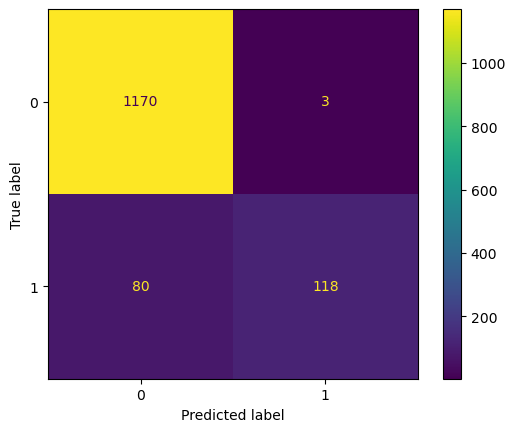

,accuracy,precision,recall,f1,TN,FP,FN,TP
Métricas en Test,0.889213,0.772727,0.34,0.472222,288,5,33,17


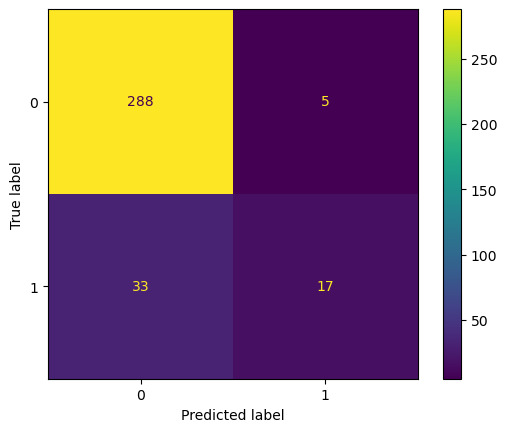

In [23]:
# Calcular el rendimiento del mejor modelo
dtc_best_model = grid_cv_2.best_estimator_

y_train_pred_dtc_adj = dtc_best_model.predict(X_train)
y_test_pred_dtc_adj = dtc_best_model.predict(X_test)

show_metrics(y_train, y_train_pred_dtc_adj, "Métricas en Train")
show_metrics(y_test, y_test_pred_dtc_adj, "Métricas en Test")

Por ello mismo, si queremos comparar respecto a los resultados obtenidos en el item anterior, tenemos lo siguiente:


In [24]:
compare_metrics(y_train, y_train_pred_dtc_def, y_train,
                y_train_pred_dtc_adj, "Train Default", "Train Ajustado")
compare_metrics(y_test, y_test_pred_dtc_def, y_test,
                y_test_pred_dtc_adj, "Test Default", "Test Ajustado")

Gracias a lo cual, podemos ver que el ajuste de los hiperparámetros permitió sacar el sobreajuste (overfitting) que teníamos en los datos de entrenamiento y mejorar el rendimiento de nuestro modelo, respecto a la _exactitud_ y _precisión_. Sin embargo, algo muy importante a destacar es la gran disminución en el _recall_ y _f1-score_ obtenidos, lo cual nos indica que el modelo puede seguir mejorando en la predicción de los casos positivos. Para ello, habría que seguir probando con más combinaciones de hiperparámetros, un K más grande en _cross validation_ o incluso probar con otro modelo (como _RandomForest_ o _GradientBoosting_).

Finalmente, y a fines ilustrativos, el árbol de decisión obtenido con los hiperparámetros ajustados es el siguiente:


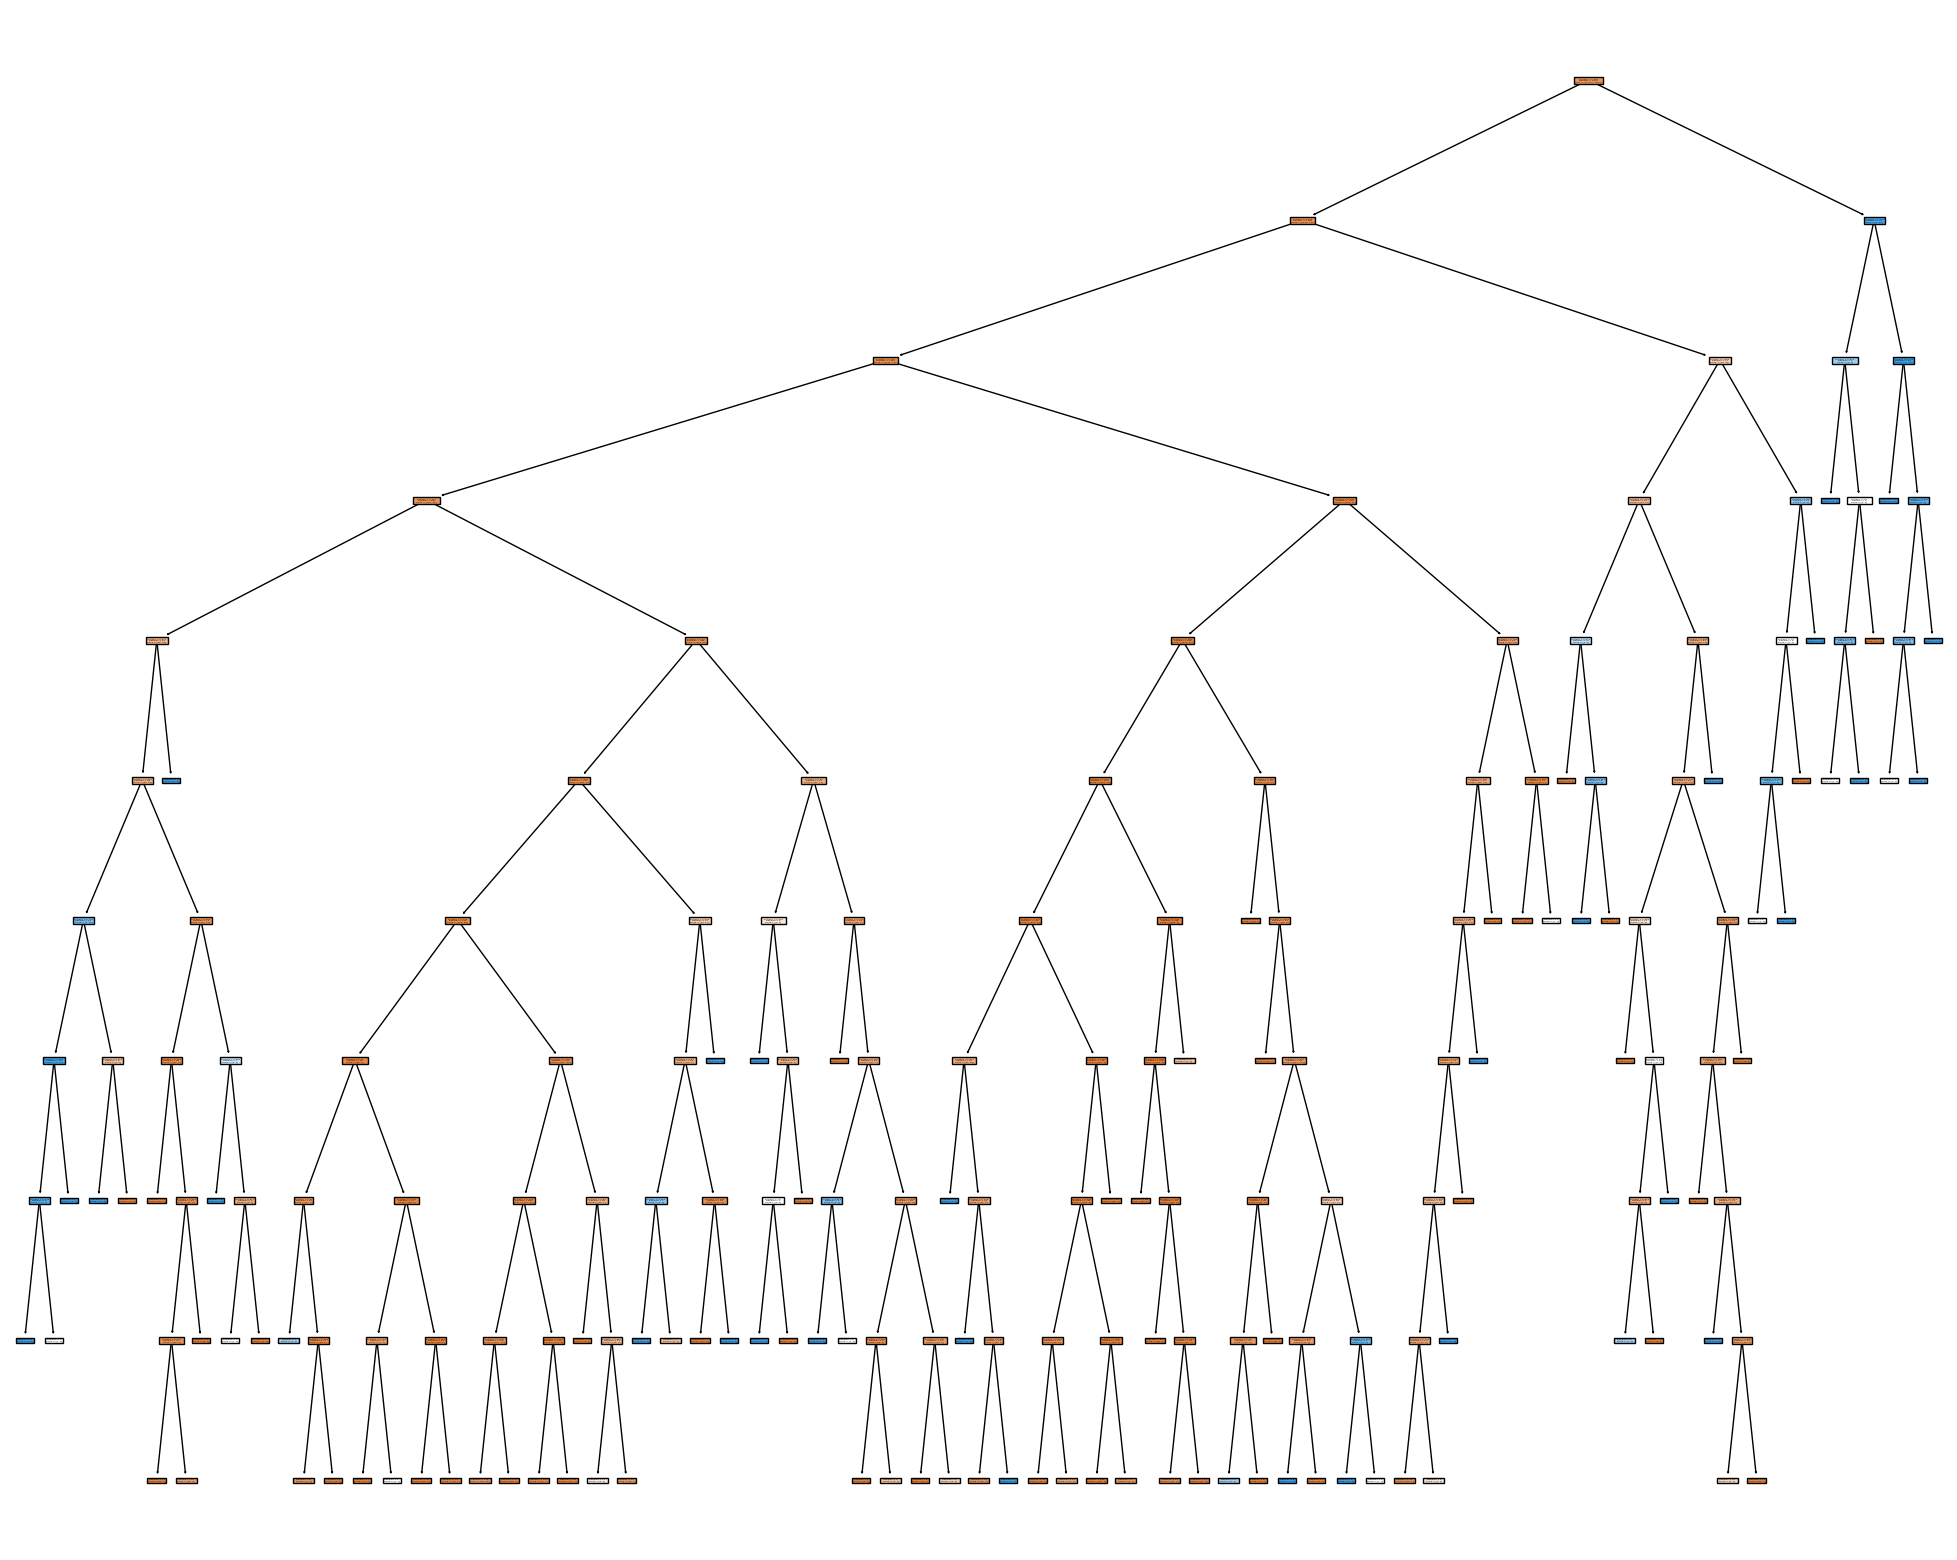

In [25]:
fig = plt.figure(figsize=(25, 20))
plot_tree(dtc_best_model, filled=True, feature_names=X.columns)
plt.show()

### 5.3. Comparación de Modelos


Si comparamos la performance de los mejores modelos obtenidos en los puntos anteriores, tenemos lo siguiente:


In [26]:
compare_metrics(y_train, y_train_pred_clf_adj, y_train,
                y_train_pred_dtc_adj, "Train SGD", "Train DecisionTree")
compare_metrics(y_test, y_test_pred_clf_adj, y_test,
                y_test_pred_dtc_adj, "Test SGD", "Test DecisionTree")

Gracias a lo cual se puede notar que el mejor modelo utilizado fue el de _DecisionTreeClassifier_ con hiperparámetros ajustados, dado que obtuvo un mejor rendimiento en todas las métricas de evaluación (excepto en la precisión de evaluación).

Por ello mismo, podemos concluir que el modelo de _DecisionTreeClassifier_ es el que mejor se ajusta a nuestro problema de predicción de _Target_ en este caso.


## 6. Conclusiones


Finalmente, entonces, gracias a la realización de este laboratorio, pudimos poner en práctica los conocimientos adquiridos en la materia, trabajando con un conjunto de datos real e introduciéndonos en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

Por ello mismo, pudimos ver que el ajuste de los hiperparámetros de los modelos es un factor importantísimo para mejorar el rendimiento de los mismos, y que el modelo de _DecisionTreeClassifier_ es el que mejor se ajusta a nuestro problema de predicción de _Target_ en este caso.
